# Preliminary operation and import packages

2.9 version of TensorFlow/Keras, some data augmentation techniques are particularly slow

In [ ]:
%pip install tensorflow-gpu==2.8.3 
%pip install -U scikit-learn

In [ ]:
%pip uninstall keras-preprocessing
%pip install git+https://github.com/keras-team/keras-preprocessing.git # flow_from_directory function in order to import image from pandas dataframe (map)

In [1]:
import tensorflow as tf 
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import cv2

from time import time
import os

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load Data

## Import labels dataframe

In [2]:
# Set the directory where the data is stored

path = 'C:/Users/marco/Desktop/Local_Documents/data'
os.chdir(path=path)

In [3]:
# Import annotation (train, test)
train_label =pd.read_csv('train_COVIDx9A.txt', sep = ' ', header=None)
test_label = pd.read_csv('test_COVIDx9A.txt', sep= ' ', header=None)

In [4]:
# Set column names and remove unnecessary ones

train_label.columns=['patient id', 'img_path', 'label', 'data source']
train_label=train_label.drop(['patient id', 'data source'], axis=1 )

test_label.columns=['patient id', 'img_path', 'label', 'data source']
test_label=test_label.drop(['patient id', 'data source'], axis=1 )

In [5]:
train_label.head(5)

,img_path,label
0,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
1,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
2,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
4,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia


In [6]:
test_label.head(5)

,img_path,label
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,COVID-19
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,COVID-19
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,COVID-19
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,COVID-19
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,COVID-19


<AxesSubplot: xlabel='label', ylabel='Count'>

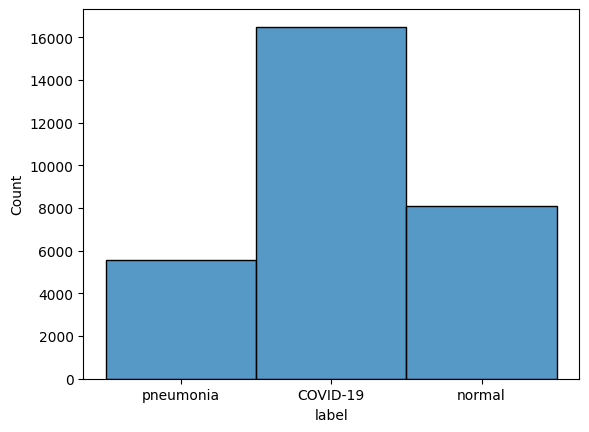

In [7]:
sns.histplot(train_label['label'], discrete=True)

In [25]:
train_label['label'].value_counts().sum()

30130

<AxesSubplot: xlabel='label', ylabel='Count'>

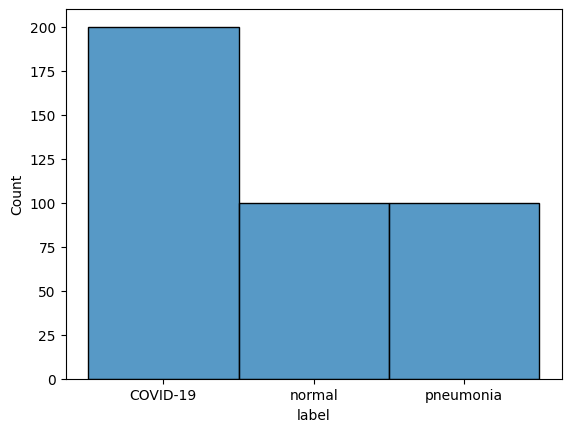

In [9]:
sns.histplot(test_label['label'], discrete=True)

In [10]:
test_label['label'].value_counts()

COVID-19     200
normal       100
pneumonia    100
Name: label, dtype: int64

## Image exploration

## Load Images

https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

In [22]:
target_size = (224,224) # Target size
batch_size = 64 # Batch size

train_path = 'C:/Users/marco/Desktop/Local_Documents/data/train/'
test_path = 'C:/Users/marco/Desktop/Local_Documents/data/test/'   

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.20)

In [50]:
os.chdir(train_path)

#Training set
train_data = datagen.flow_from_dataframe(
dataframe=train_label,
directory=train_path,
x_col="img_path",
y_col="label",
subset="training",
batch_size=batch_size,
seed=123,
shuffle=True,
class_mode="categorical",
target_size=target_size)

Found 23708 validated image filenames belonging to 3 classes.


c:\Users\marco\Documents\venv\DL\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:283: UserWarning: Found 496 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [55]:
os.chdir(train_path)

# Validation set
validation_data = datagen.flow_from_dataframe(
dataframe=train_label,
directory=train_path,
x_col="img_path",
y_col="label",
subset="validation",
batch_size=batch_size,
seed=123,
shuffle=True,
class_mode="categorical",
target_size=target_size)

Found 5926 validated image filenames belonging to 3 classes.


c:\Users\marco\Documents\venv\DL\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:283: UserWarning: Found 496 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [52]:
os.chdir(test_path)

# Test set
test_data = datagen.flow_from_dataframe(
dataframe=test_label,
directory=test_path,
x_col="img_path",
y_col=None,
batch_size=batch_size,
seed=123,
shuffle=False,
class_mode=None,
target_size=target_size)

Found 400 validated image filenames.


In [30]:
train_data

In [34]:
class_names = train_data.class_indices
print(class_names)

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


# Prove

In [40]:
num_classes = 3

In [57]:
# Architecture definition (v1)
inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)

x = keras.layers.Conv2D(64, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net = keras.Model(inputs, outputs)

In [45]:
net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 activation_2 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 activation_3 (Activation)   (None, 75, 75, 64)        0         
                                                           

In [58]:
# Compile the model for training
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
history = net.fit_generator(train_data,
          epochs=5,
          validation_data=validation_data)